In [1]:
### ADAPTED FROM SENTDEX' Kaggle Dogs vs Cats CNN Solution ### 

# Pre-req installts needed
#_________________________
# pip3 intall --upgrade tensorflow-gpu
# pip install tflearn
# pip install tqdm
# 

import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'C:/COSC_490_Project/dataset/training_set'
TEST_DIR = 'C:/COSC_490_Project/dataset/test_set'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '6conv-basic-video')

In [2]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1, 0]
    elif word_label == 'dog' : return [0, 1]

In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data
# THIS SHOULD ONLY BE DONE 1 TIME ON DATA SET 

In [4]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    
    np.save('test_data.npy', testing_data)
    return testing_data

In [8]:
#train_data = create_train_data()
# if you already have train data:
train_data = np.load('train_data.npy', allow_pickle=True)

In [9]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
with tf.device('/gpu:0'):
    sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    #sess = tf.Session()
    tf.reset_default_graph()

    convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

    convnet = conv_2d(convnet, 32, 2, activation='relu')
    convnet = max_pool_2d(convnet, 2)

    convnet = conv_2d(convnet, 32, 2, activation='relu')
    convnet = max_pool_2d(convnet, 2)

    convnet = conv_2d(convnet, 32, 2, activation='relu')
    convnet = max_pool_2d(convnet, 2)

    
    convnet = conv_2d(convnet, 32, 2, activation='relu')
    convnet = max_pool_2d(convnet, 2)

    convnet = conv_2d(convnet, 32, 2, activation='relu')
    convnet = max_pool_2d(convnet, 2)

    convnet = conv_2d(convnet, 32, 2, activation='relu')
    convnet = max_pool_2d(convnet, 2)

    convnet = fully_connected(convnet, 1024, activation='relu')
    convnet = dropout(convnet, 0.8)

    convnet = fully_connected(convnet, 2, activation='softmax')
    convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

    model = tflearn.DNN(convnet, tensorboard_dir='log')

curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [10]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from c:\COSC_490_Project\dogsvscats-0.001-6conv-basic-video.model
model loaded!


In [11]:
train = train_data[:-500]
test = train_data[-500:]

In [12]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [ ]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

In [13]:
#tensorboard --logdir=foo:C:\COSC_490_Project\log

In [14]:
model.save(MODEL_NAME)

INFO:tensorflow:c:\COSC_490_Project\dogsvscats-0.001-6conv-basic-video.model is not in all_model_checkpoint_paths. Manually adding it.


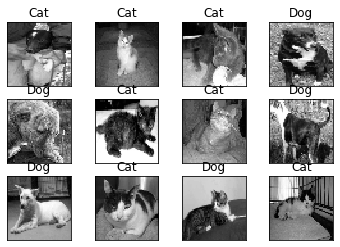

In [16]:
import matplotlib.pyplot as plt

#if file DNE
#test_data = process_test_data()
#else
test_data = np.load('test_data.npy', allow_pickle=True)

fig = plt.figure()
#allow_pickle = true
for num, data in enumerate(test_data[:12]):
    #cat: [1,0]
    #dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data 
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label = 'Cat'
            
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [17]:
with open('submission-file.csv', 'w') as f:
    f.write('id,label\n')

In [18]:
with open('submission-file.csv', 'a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data 
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        
        f.write('{},{}\n'.format(img_num, model_out[1]))

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:14<00:00, 870.17it/s]
